Rusty Bargain used car sales service is developing an app to attract new customers. In that app, you can quickly find out the market value of your car. You have access to historical data: technical specifications, trim versions, and prices. You need to build the model to determine the value. 

Rusty Bargain is interested in:

- the quality of the prediction;
- the speed of the prediction;
- the time required for training

DateCrawled — date profile was downloaded from the database

VehicleType — vehicle body type

RegistrationYear — vehicle registration year

Gearbox — gearbox type

Power — power (hp)

Model — vehicle model

Mileage — mileage (measured in km due to dataset's regional specifics)

RegistrationMonth — vehicle registration month

FuelType — fuel type

Brand — vehicle brand

NotRepaired — vehicle repaired or not

DateCreated — date of profile creation

NumberOfPictures — number of vehicle pictures

PostalCode — postal code of profile owner (user)

LastSeen — date of the last activity of the user

Target

Price — price (Euro)

# Introduction

# Data Collection

The data was given by TripleTen, and the data was accessed using the pandas library in Python.

## Importing Libraries

Below are the libraries that will be used for this project.

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from IPython.display import display
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from scipy.stats import f_oneway
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import category_encoders as ce
from pandas.api import types as ptypes
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import scipy.stats as stats

# Global Changes

There are some formatting options that we need to adjust so that we can better see certain tables and other figure types.

In [2]:
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)

## Accessing CSV file

We need to access the given CSV file so we do this below.

In [3]:
#This is the name of the file path
#file_path = "/datasets/car_data.csv"
file_path = "/Users/tanner/Downloads/car_data.csv"
#file_path = "/Users/tanne/Desktop/sprint12folder/car_data.csv"

#This is the csv file that contains all of the information that we will use for this project --> there will be no modifications to it
raw_df = pd.read_csv(file_path)

# Initial Inspection

The initial inspection of our given data consists of minor edits that, in short, do not cause data leakage of any form. Any kind of edit that does not require the splitting of our data into training, validation, or testing data will be presented here.

## Inspecting the CSV file for General Information

In [4]:
#Here is the general info for the file
print(raw_df.info(), "\n\n", raw_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

We see obvious corrections that need to be made: First, the data types of DateCrawled, Gearbox, RegistrationMonth, NotRepaired, DateCreated, and LastSeen need to be converted to appropriate data types--the specifics will be demonstrated in the next few sections. Second, several columns that have null values so those need to be imputed or removed. There are likely other modifications that need to be made, which we start by discovering in the initial inspection.

In [5]:
#Here are the statistical measurements of the data
print(raw_df.describe())

               Price  RegistrationYear          Power        Mileage  \
count  354369.000000     354369.000000  354369.000000  354369.000000   
mean     4416.656776       2004.234448     110.094337  128211.172535   
std      4514.158514         90.227958     189.850405   37905.341530   
min         0.000000       1000.000000       0.000000    5000.000000   
25%      1050.000000       1999.000000      69.000000  125000.000000   
50%      2700.000000       2003.000000     105.000000  150000.000000   
75%      6400.000000       2008.000000     143.000000  150000.000000   
max     20000.000000       9999.000000   20000.000000  150000.000000   

       RegistrationMonth  NumberOfPictures     PostalCode  
count      354369.000000          354369.0  354369.000000  
mean            5.714645               0.0   50508.689087  
std             3.726421               0.0   25783.096248  
min             0.000000               0.0    1067.000000  
25%             3.000000               0.0   30165.

Frankly, by the nature of what the column data represents, much of the statistical data is unusable. For example, the standard deviation of the PostalCode column does not acquire significant meaning. However, some measurements may be used in this project at some point.

## Dropping NumberOfPictures Column

Let's check the values within the NumberOfPictures column.

In [6]:
print(raw_df['NumberOfPictures'].value_counts(dropna=False))

NumberOfPictures
0    354369
Name: count, dtype: int64


The column only contains a single value, 0. Therefore, this will not be useful for either analysis nor machine learning so we can delete it.

In [7]:
#We now create a dataframe that contains the formatted data that we will work with. This ensure we keep a copy of the dataframe that has no editing done to it
formatted_df = raw_df.copy(deep = True)

#Here we drop the NumberOfPictures column
formatted_df.drop(columns=['NumberOfPictures'], inplace=True)

In [8]:
#Ensure that the column was dropped
print("Remaining columns: \n\n")

for column in formatted_df.columns:
    print(column)

Remaining columns: 


DateCrawled
Price
VehicleType
RegistrationYear
Gearbox
Power
Model
Mileage
RegistrationMonth
FuelType
Brand
NotRepaired
DateCreated
PostalCode
LastSeen


We see that the dropping of this column was executed.

## Changing Various Columns to DateTime Format

The columns DateCrawled, DateCreated, and LastSeen are converted to DateTime type because extracting date-related information from object-type dates is cumbersome--contrary to the versatility of DateTime type.

In [9]:
#Here are the first 10 entries of the DateCrawled, DateCreated, and Last seen Columns

#Datecrawled
print(formatted_df['DateCrawled'].head(5))

#DateCreated
print(formatted_df['DateCreated'].head(5))

#LastSeen
print(formatted_df['LastSeen'].head(5))

0    24/03/2016 11:52
1    24/03/2016 10:58
2    14/03/2016 12:52
3    17/03/2016 16:54
4    31/03/2016 17:25
Name: DateCrawled, dtype: object
0    24/03/2016 00:00
1    24/03/2016 00:00
2    14/03/2016 00:00
3    17/03/2016 00:00
4    31/03/2016 00:00
Name: DateCreated, dtype: object
0    07/04/2016 03:16
1    07/04/2016 01:46
2    05/04/2016 12:47
3    17/03/2016 17:40
4    06/04/2016 10:17
Name: LastSeen, dtype: object


We need to convert these columns into datetime format.

In [10]:
"""
Here we convert the aformentioned columns to datetime format, and the month will be displayed first in our datetime
objects since that is the standard description of a date in the US.
"""

#Here we convert the DateCrawled column to datetime format
formatted_df['DateCrawled'] = pd.to_datetime(formatted_df['DateCrawled'], errors = 'coerce', dayfirst = True)

#Here we convert the DateCreated column to datetime format
formatted_df['DateCreated'] = pd.to_datetime(formatted_df['DateCreated'], errors='coerce', dayfirst = True)

#Here we convert the LastSeen column to datetime format
formatted_df['LastSeen'] = pd.to_datetime(formatted_df['LastSeen'], errors='coerce', dayfirst=True)

Let's check to see if the changes were made

In [11]:
#Check to see if DateCrawled, DateCreated, and LastSeen were converted to datetime format correctly
print(formatted_df[['DateCrawled', 'DateCreated', 'LastSeen']].info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   DateCrawled  354369 non-null  datetime64[ns]
 1   DateCreated  354369 non-null  datetime64[ns]
 2   LastSeen     354369 non-null  datetime64[ns]
dtypes: datetime64[ns](3)
memory usage: 8.1 MB
None


Clearly the columns were properly converted to datetime type.

## Checking Registration Month Feature

The analysis of the colums is under the EDA section. To recap from the EDA's results, there's no discernable correlation between registration month and target. They all have relatively similar quartiles and medians, as well a, similar clusters of outliers. We do have a column of 'month 0', which is likely a typo or a placeholder for null values. Imputing these this categoriy with the mode would likely not change anything--except for the mode itself. Therefore, we can safely drop this column so that we do not use it as a feature in the training and testing of our models.

In [12]:
formatted_df = formatted_df.drop(columns=['RegistrationMonth'])

Let's check to ensure that the RegistrationMonth columns was dropped.

In [13]:
print(formatted_df.columns)

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Mileage', 'FuelType', 'Brand', 'NotRepaired',
       'DateCreated', 'PostalCode', 'LastSeen'],
      dtype='object')


# Splitting the Data

Now that we have finished the minor edits within our dataset, we need to split it into training, validation, and testing data subsets. This is performed so that we prevent any form of data leakage during exploratory data analysis and model training.

In [14]:
#Here we define the potential target (some could be deleted later) and feature columns
target = formatted_df['Price']
potential_features = formatted_df.drop(columns=['Price'])

#Now we are going to split the data into temporary training and testing data
X_temp, X_test, y_temp, y_test = train_test_split(potential_features, target, test_size=0.2, random_state=12345)

#Now we will split the temporary training data into training and validation data
X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=0.25, random_state=12345)

# Exploratory Data Analysis before Preprocessing

The purpose of this section is to do EDA on our data which has undergone minor formatting. There are statistical tests that we cannot perform until the data has been completely preprocessed; thus, after the complete preprocessing of our data, there will be another EDA section exploring deeper patterns in the data. The analysis in this section is to spot issues in our data and to acquire basic understanding about it.

Column definitions
df_name

The name you passed into the function (like "X_train_linear"), so you can remember which DataFrame the profile came from.

column

The name of the column being analyzed.

dtype

The column’s data type (int64, float64, object, datetime64[ns], etc.).

null_count

The total number of missing (NaN) values in the column.

missing_pct

The percentage of missing values in the column, relative to the total rows in that DataFrame.

duplicate_count

The number of rows in which this column’s value is duplicated somewhere else in that same column (i.e., how many entries are repeats).

unique_count

How many distinct values are present in the column.

rare_level_count

How many unique values appear 5 times or fewer in the column.

This is useful in categorical features where some categories are too rare to be statistically useful — often candidates for grouping together.

mean

The arithmetic mean (average) of the column (numeric columns only, otherwise NaN).

median

The median value of the column (numeric columns only).

std

The standard deviation — tells you how spread out the values are.

In this section, we will perform analysis on both of our training datasets: X_train and y_train. More specificially, we will visualize some of the distributions within these columns, explore relationships between potential features and the target, and more. This information will be used in the preprocessing of our data, which is the next section.

## Helper Functions for Data Analysis

In [15]:
def column_profile(df: pd.DataFrame, column: str, df_name: str = "df") -> pd.DataFrame:
    """
    Create a one-row summary table for a single column in a DataFrame.
    Adapts to numeric, categorical, or datetime columns.
    """
    if column not in df.columns:
        raise KeyError(f"Column '{column}' not found in DataFrame.")
        
    s = df[column]
    n_rows = len(s)
    dtype = str(s.dtype)
    
    missing_count = int(s.isna().sum())
    missing_pct = float(missing_count / n_rows * 100) if n_rows else np.nan
    
    # duplicates among non-null values (count entries that repeat beyond their first occurrence)
    non_null = s.dropna()
    duplicates_count = int(non_null.size - non_null.nunique())
    
    unique_count = int(non_null.nunique())
    
    # Base row
    out = {
        "dataframe_name": df_name,
        "column_name": column,
        "dtype": dtype,
        "n_rows": n_rows,
        "missing_count": missing_count,
        "missing_pct": round(missing_pct, 3),
        "unique_count": unique_count,
        "duplicate_values_in_column": duplicates_count,
    }
    
    # Most frequent (mode) value and its count (on non-null values)
    if non_null.size > 0:
        vc = non_null.value_counts(dropna=True)
        top_value = vc.index[0]
        top_value_count = int(vc.iloc[0])
        out["top_value"] = top_value
        out["top_value_count"] = top_value_count
    else:
        out["top_value"] = np.nan
        out["top_value_count"] = 0

    # Numeric extras
    if ptypes.is_numeric_dtype(s):
        s_num = pd.to_numeric(s, errors="coerce").dropna()
        if s_num.size > 0:
            out.update({
                "min": float(s_num.min()),
                "q25": float(s_num.quantile(0.25)),
                "median": float(s_num.median()),
                "q75": float(s_num.quantile(0.75)),
                "max": float(s_num.max()),
                "mean": float(s_num.mean()),
                "std": float(s_num.std(ddof=1)) if s_num.size > 1 else 0.0,
                "skew": float(s_num.skew()) if s_num.size > 2 else np.nan,
                "kurtosis": float(s_num.kurt()) if s_num.size > 3 else np.nan,
                "zero_count": int((s_num == 0).sum()),
                "negative_count": int((s_num < 0).sum()),
            })
            # IQR outlier count (1.5*IQR rule)
            q1, q3 = s_num.quantile([0.25, 0.75])
            iqr = q3 - q1
            lower = q1 - 1.5 * iqr
            upper = q3 + 1.5 * iqr
            out["iqr_outlier_count"] = int(((s_num < lower) | (s_num > upper)).sum())
        else:
            out.update({
                "min": np.nan, "q25": np.nan, "median": np.nan, "q75": np.nan,
                "max": np.nan, "mean": np.nan, "std": np.nan, "skew": np.nan,
                "kurtosis": np.nan, "zero_count": 0, "negative_count": 0,
                "iqr_outlier_count": 0
            })
    
    # Datetime extras
    elif ptypes.is_datetime64_any_dtype(s):
        s_dt = s.dropna()
        if s_dt.size > 0:
            min_date = s_dt.min()
            max_date = s_dt.max()
            span_days = (max_date - min_date).days
            out.update({
                "min_date": min_date,
                "max_date": max_date,
                "span_days": int(span_days),
                "min_year": int(min_date.year),
                "max_year": int(max_date.year),
            })
        else:
            out.update({
                "min_date": pd.NaT, "max_date": pd.NaT, "span_days": np.nan,
                "min_year": np.nan, "max_year": np.nan
            })
    
    # Categorical / object / boolean extras
    else:
        # treat as categorical
        s_cat = s.astype("object")
        vc = s_cat.value_counts(dropna=True)
        top5 = [f"{str(idx)}:{int(cnt)}" for idx, cnt in vc.head(5).items()]
        out["top_5_levels"] = ", ".join(top5)
        total_non_null = int(s_cat.notna().sum())
        if total_non_null > 0:
            rare_levels_count = int((vc / total_non_null < 0.01).sum())
        else:
            rare_levels_count = 0
        out["rare_levels_count(<1%)"] = rare_levels_count
        # empty-string count
        try:
            empty_count = int((s_cat.fillna("").astype(str).str.strip() == "").sum())
        except Exception:
            empty_count = np.nan
        out["empty_string_count"] = empty_count

    return pd.DataFrame([out])


def profile_columns(df: pd.DataFrame, columns, df_name: str = "df") -> pd.DataFrame:
    """Profile multiple columns and return a summary table."""
    if isinstance(columns, str):
        columns = [columns]
    tables = [column_profile(df, col, df_name=df_name) for col in columns if col in df.columns]
    if not tables:
        raise ValueError("None of the specified columns were found in the DataFrame.")
    summary = pd.concat(tables, ignore_index=True)
    return summary

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def eda_categorical_overview(df, col, top_n=20, rare_pct=1.0, df_name="df"):
    s = df[col]

    # counts (exclude NaN for category stats; keep NaN for missing calc)
    counts = s.value_counts(dropna=True)
    n = len(s)
    total_non_null = s.notna().sum()

    # summary numbers
    missing_count = int(s.isna().sum())
    missing_pct = (missing_count / n * 100) if n else np.nan
    unique_count = int(s.nunique(dropna=True))
    empty_count = int(s.astype("object").fillna("").str.strip().eq("").sum())

    rare_levels_count = int(((counts / counts.sum()) * 100 < rare_pct).sum())
    topK = counts.head(top_n)
    topK_coverage_pct = float(topK.sum() / counts.sum() * 100) if counts.sum() else np.nan

    # summary table
    summary = pd.DataFrame([{
        "dataframe": df_name,
        "column": col,
        "rows": n,
        "missing_count": missing_count,
        "missing_pct": round(missing_pct, 2),
        "unique_count": unique_count,
        "empty_string_count": empty_count,
        f"rare_levels_count(<{rare_pct}%)": rare_levels_count,
        f"top{top_n}_coverage_pct": round(topK_coverage_pct, 1),
        "most_common": counts.index[0] if len(counts) else None,
        "most_common_count": int(counts.iloc[0]) if len(counts) else 0
    }])

    # display summary nicely
    try:
        from IPython.display import display
        display(summary.style.format({
            "missing_pct": "{:.2f}",
            f"top{top_n}_coverage_pct": "{:.1f}"
        }))
    except Exception:
        print(summary)

    # ---- Plot 1: Pareto of ALL categories (keeps full distribution) ----
    sorted_counts = counts.sort_values(ascending=False)
    cum_pct = sorted_counts.cumsum() / sorted_counts.sum() * 100 if sorted_counts.sum() else pd.Series([])

    fig, ax1 = plt.subplots(figsize=(10, 4))
    ax1.bar(range(len(sorted_counts)), sorted_counts.values)
    ax1.set_xlabel(f"{col} (sorted by frequency)")
    ax1.set_ylabel("Count")

    ax2 = ax1.twinx()
    ax2.plot(range(len(cum_pct)), cum_pct.values, color="crimson")
    ax2.set_ylabel("Cumulative % of rows")
    ax2.axhline(80, color="gray", ls="--", lw=1)   # 80/20 guideline
    plt.title(f"Pareto of '{col}' (full distribution)")
    plt.tight_layout()
    plt.show()

    # ---- Plot 2: Top-N categories (readable labels) ----
    plt.figure(figsize=(10, 6))
    sns.barplot(x=topK.values, y=topK.index)
    plt.xlabel("Count")
    plt.ylabel(col)
    plt.title(f"Top {top_n} '{col}' (covers {topK_coverage_pct:.1f}% of non-missing)")
    plt.tight_layout()
    plt.show()

    return summary




## Analysis of Price

Let's check the first few entries of our target column (Price --> tree models only).

In [16]:
#First few entires of the price column
print(y_train.head(10))

232808    1000
271287       0
239322    4750
302334    3900
307563    7790
226979     700
335294     550
299469    7800
303288    2800
75840     3900
Name: Price, dtype: int64


Let's see the general statistics for this column.

In [17]:
#General statistics for our target
print(y_train.describe())

count    212621.000000
mean       4418.165172
std        4517.006078
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: Price, dtype: float64


We see that the minimum price of cars is 0, which is likely a typo or some kind of null entry. It would be ideal to filter the price of vehicles to something more realistic, 100 for example. We will check the sum of relative frequencies of prices from 0 - 99 to ensure we do not lose too much data. In addition, the price column has a mean of 4408 and a median of 2700, indicating that we have heavy outliers that are pulling the mean to be bigger than the median. This suggests that our distirbution is skewed right. The spread of this data is also considerable because our standard deviation is 4504. 

Let's check the sum of relative frequences of prices ranging from 0 - 99 so that we may know if it is safe to remove rows in our dataframe that contain any of these prices.

In [18]:
#This is the number of entries in our training target (y_train)
price_entries = len(y_train)

#We filter the y_train to only include prices ranging from 0 - 99
filtered_prices_series= y_train[(y_train >= 0) & (y_train < 100)]

#This is the number of rows that y_train contains. This is used to calculate the relative frequency.
number_rows_filtered_prices = filtered_prices_series.shape[0]

#Relative frequency calculation
relative_frequency = number_rows_filtered_prices / price_entries

#Result
print(f'Relative frequency: {relative_frequency * 100:.2f} %')

Relative frequency: 3.75 %


The prices ranging from 0 - 99 only compromise of roughly 4% of the data. Therefore, we are going to filter out these prices values so that we get an accurate depiction of our distribution when we graph it. Typically changes are reserved for the preprocessing; however, the analysese of various columns depend on reliable prices. Therefore, we make an exception for the target and do some preprocessing of it early in this section.

In [19]:
#Since we are going to filter y_train, the indexes will change, so we also need to account for this in X_train. Thus we create a mask.
mask = y_train >= 100

#Now we filter both X_train and y_train using the mask
X_train = X_train[mask].reset_index(drop=True)
y_train = y_train[mask].reset_index(drop=True)

Let's ensure that changes took place and then we can visualize our distribution.

In [20]:
print(y_train.describe())

count    204643.000000
mean       4590.203941
std        4517.738273
min         100.000000
25%        1200.000000
50%        2900.000000
75%        6500.000000
max       20000.000000
Name: Price, dtype: float64


Let's take a look at the distribution of values in this target and calculate skewness.

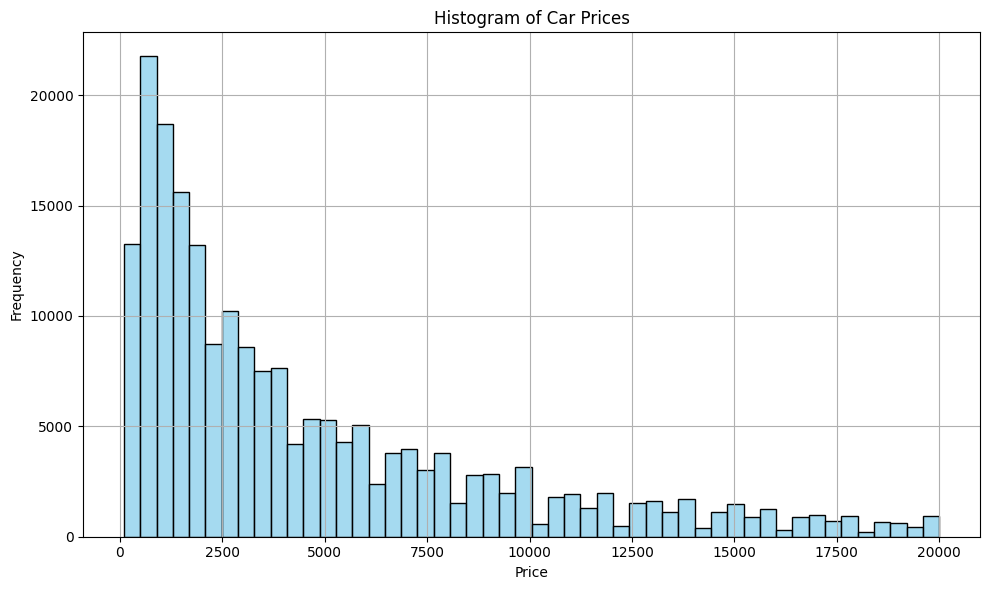

In [21]:
plt.figure(figsize=(10,6))
sns.histplot(data=y_train, bins=50, kde=False, color='skyblue')

plt.title('Histogram of Car Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

In [22]:
print(y_train.skew())

1.4071341775530768


Since our distribution has a skewness of 1.41 and our graph is visually skewed to the right, a log transformation will be implemented since we are using linear regression in our models later on. This helps with the normality assumption with linear regression.

In [23]:
zero_count_valid = (y_valid == 0).sum()
print(f"Number of zero entries in y_valid: {zero_count_valid}")

zero_count_test = (y_test == 0).sum()
print(f"Number of zero entries in y_test: {zero_count_test}")

print(y_valid.info())
print(y_test.info())

Number of zero entries in y_valid: 2106
Number of zero entries in y_test: 2202
<class 'pandas.core.series.Series'>
Index: 70874 entries, 112497 to 163381
Series name: Price
Non-Null Count  Dtype
--------------  -----
70874 non-null  int64
dtypes: int64(1)
memory usage: 1.1 MB
None
<class 'pandas.core.series.Series'>
Index: 70874 entries, 18734 to 301411
Series name: Price
Non-Null Count  Dtype
--------------  -----
70874 non-null  int64
dtypes: int64(1)
memory usage: 1.1 MB
None


In [24]:
#We have to disccard zeros for y_valid and y_test so we are using the log transformation

#Creating a mask to filter out zeros in y_valid and y_test
mask_valid = y_valid > 0
mask_test = y_test > 0

#Now we filter both X and y (validation and testing) sets accordingly
X_valid = X_valid[mask_valid].reset_index(drop=True)
y_valid = y_valid[mask_valid].reset_index(drop=True)

X_test = X_test[mask_test].reset_index(drop=True)
y_test = y_test[mask_test].reset_index(drop=True)   

#Log transformation of our prices --> we need to do this for all target series'
y_train_log = np.log(y_train)
y_valid_log = np.log(y_valid)
y_test_log = np.log(y_test)

Now let's compare the distibutions visually and calculate the skewness of the log distribution.

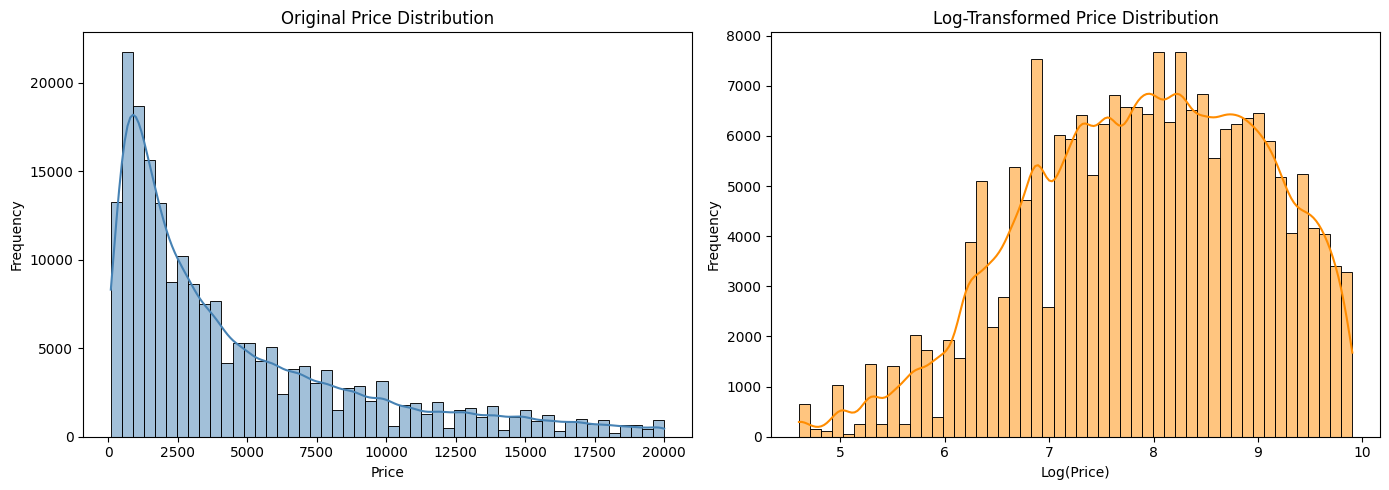

In [25]:
plt.figure(figsize=(14, 5))

# Original Price Distribution
plt.subplot(1, 2, 1)
sns.histplot(data=y_train, bins=50, kde=True, color='steelblue')
plt.title('Original Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')

# Log-Transformed Price Distribution
plt.subplot(1, 2, 2)
sns.histplot(data=y_train_log, bins=50, kde=True, color='darkorange')
plt.title('Log-Transformed Price Distribution')
plt.xlabel('Log(Price)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [26]:
#Skewness before log transformation
print("Skewness of original prices:", y_train.skew())
print("")

#Skewness of log prices
print("Skewness of log prices:", y_train_log.skew())

Skewness of original prices: 1.4071341775530768

Skewness of log prices: -0.33127801666330886


We now see that our skewness has decreased from 1.41 to -0.32, a good improvement for us when we have to train a linear regression model later. Note that LogPrice will not be the target for our tree model.

## Analysis of Model

In [27]:
#Here is some general information about the model column
print("General information about the Model column:\n")
print(X_train['Model'].info())


General information about the Model column:

<class 'pandas.core.series.Series'>
RangeIndex: 204643 entries, 0 to 204642
Series name: Model
Non-Null Count   Dtype 
--------------   ----- 
194503 non-null  object
dtypes: object(1)
memory usage: 1.6+ MB
None


We clearly see that we have some existing null values within this column. The object type is appropriate since this column stores the various car models. Of course, if we use this column as a feature, then we will have to encode it later for modeling purposes. Let's get more information on this column.

In [28]:
#More general information about our Model column
model_info = column_profile(X_train, 'Model', "Model")

#Results
display(model_info)

,dataframe_name,column_name,dtype,n_rows,missing_count,missing_pct,unique_count,duplicate_values_in_column,top_value,top_value_count,top_5_levels,rare_levels_count(<1%),empty_string_count
0,Model,Model,object,204643,10140,4.955,250,194253,golf,16871,"golf:16871, other:14130, 3er:11475, polo:7601,...",224,10140


Missing values make up roughly 5% of our data. Moreover, the only way to impute these categorical missing values is to impute them with the mode. However, this could lead to unexpected issues such as assigning a car model with a brand that does acquire that particular model, which is formatting data in a way that is misrepresentative. Therefore, the null values should be removed. This is usually performed in the preprocessing, but we will need to delete them now so that we can perform some statistical tests.

In [29]:
#This is the number of nulls before we drop them
null_count_before = X_train['Model'].isnull().sum()

#Creating the mask used for X_train and y_train
mask = X_train['Model'].notna()

#Filtering using the mask
X_train = X_train.loc[mask].reset_index(drop=True)
y_train = y_train.loc[mask].reset_index(drop=True)

#Results
print(f"Dropped {null_count_before} rows from training data due to null 'Model'")
print(f"Remaining rows: {len(X_train)}")

Dropped 10140 rows from training data due to null 'Model'
Remaining rows: 194503


Our null values were successfully dropped. Now can check the distribution of this column to see if we can infer anything from it.

  dataframe column    rows  missing_count  missing_pct  unique_count  \
0   X_train  Model  194503              0          0.0           250   

   empty_string_count  rare_levels_count(<1.0%)  top25_coverage_pct  \
0                   0                       224                65.0   

  most_common  most_common_count  
0        golf              16871  


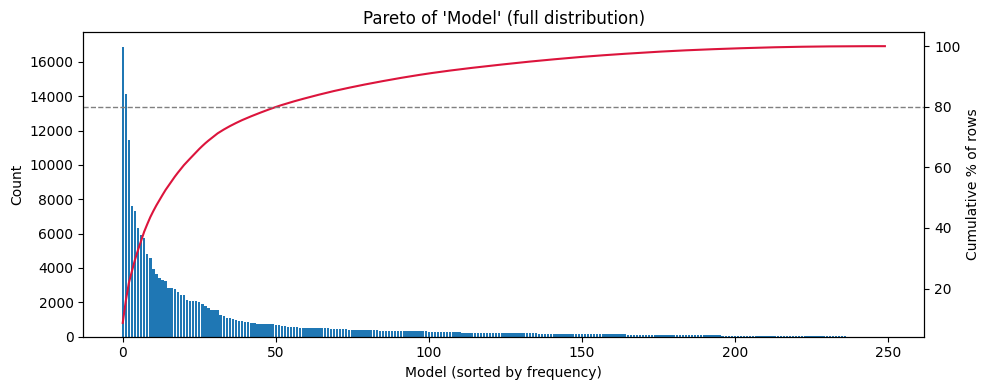

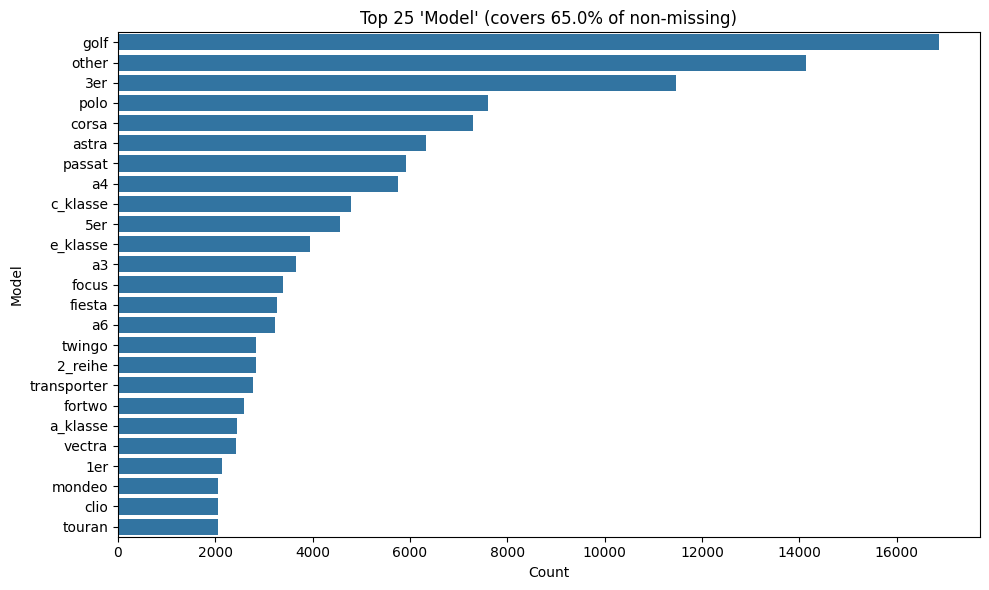

In [30]:
# Example for your Model column on the training set
summary_model = eda_categorical_overview(X_train, "Model", top_n=25, rare_pct=1.0, df_name="X_train")

The Model column has a high cardinality with 250 unique car models. Few models make up the majority of the data: the top 25 models make up 65% of the model frequencies with 'golf' being the mode. The distribution is greatly unbalanced with a right tail of rare models appearing very few times. This unbalance should be dealt with in the preprocessing of our data to prevent any instability during model training.

Now that we have removed the null values in our column, we can see if car model is statistically significant in determining car price. We may be able to do an ANOVA test, but first we need to ensure that none of the ANOVA assumptions are violated such as normality of residuals and homoscedasticity. 

In [31]:
"""
We are going to perform the Leven test for homogeneity of variances and the Shapiro-Wilk test for normality of residuals, which are required assumptions for the ANOVA test.
If we pass these tests, we may be able to perform an ANOVA test on our Model column to see if it is a statistical factor in determining a car's price.
If we fail the tests, then we will have to use a non-parametric test such as the Kruskal-wallis test.

First we check to see if X_train and y_train have the same shape, unique indexes, and aligning indexes. This is important because we have to concatenate
them into a dataframe to do the statistical tests that we are interested in.
"""

#Ensuring X_train and y_train have the same number of rows
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

#Ensuring the indexes are unique
print("X_train index unique?", X_train.index.is_unique)
print("y_train index unique?", y_train.index.is_unique)

#Ensuring that they have the same index
print("Indexes exactly equal?", X_train.index.equals(y_train.index))

#Here we concatenate the potential features and the target
test_df = pd.concat([X_train, y_train], axis = 1)

#Here is the shape of our test dataframe
print("After concatenation: ", test_df.shape)

X_train shape: (194503, 13)
y_train shape: (194503,)
X_train index unique? True
y_train index unique? True
Indexes exactly equal? True
After concatenation:  (194503, 14)


Now that we have our usable dataframe, we can test for the assumptions needed to perform an ANOVA test on the data.

In [32]:
"""Levene's Test"""

#First we create a list of arrays that contain the prices per car model. Note that each array corresponds to a different car model
prices_by_model = [dataframe['Price'].values for model, dataframe in test_df.groupby('Model')]

#Performing Levene test --> we acquire the Levene statistic and the p-value
lev_stat, lev_p = stats.levene(*prices_by_model)

#Message to see if we have violated homogeneity of variances
levene_message = "Not violated (p >= 0.05)" if lev_p >= 0.05 else "Violated (p < 0.05)"

#Result
print(f"Levene's test p-value: {lev_p:.3g} -> {levene_message}")


Levene's test p-value: 0 -> Violated (p < 0.05)


By Levene's test, we have violated the assumption that our car models have homogeneitic variances. This certainly weakens our ability to use the ANOVA test. However, to be thorough, we will also check to see if the model column has normality of its residuals. 

In [33]:
#Here we perform for the Shapiro-Wilk test on a subset of our data because it is sensitive to larger samples

#We store the normality results in this dictionary
normality_results = {}

for model in test_df['Model'].value_counts().index[:5]:
    vals = test_df.loc[test_df['Model'] == model, 'Price'].values
    if len(vals) >= 3:
        stat, p = stats.shapiro(vals[:200])
        normality_results[model] = 0

violations = {m:p for m,p in normality_results.items() if p < 0.05}

print("Shapiro–Wilk sample p-values:", {k: float(v) for k,v in normality_results.items()})
print(f"Normality (sample): {'Violated' if len(violations)>0 else 'Not violated'}")

Shapiro–Wilk sample p-values: {'golf': 0.0, 'other': 0.0, '3er': 0.0, 'polo': 0.0, 'corsa': 0.0}
Normality (sample): Violated


Similar to Levene's test, we have also violated the assumption that our data has normally distributed residuals. Since our data does not have the assumptions needed to perform the ANOVA test, we can perform a non-parametric test called the Kruskal-Wallis test. The assumptions that are needed for this test are the following: our observations are independent, we have an ordinal or continuous dependent variable (Price), our groups are independent, and we have the same distribution shape across our groups.

In [34]:
#Performing the Kruskal-Wallis test
stat, p_value = stats.kruskal(*prices_by_model)

#Results
print("Kruskal-Wallis H-statistic", stat)
print("p-value:", p_value)

# Interpretation
if p_value < 0.05:
    print("Significant differences in median prices exist between at least two car models.")
else:
    print("No statistically significant difference in median prices between car models.")

Kruskal-Wallis H-statistic 59338.769793340274
p-value: 0.0
Significant differences in median prices exist between at least two car models.


With our incredibly low p-value, we can say with confidence that our car models are significant factors in determining the price of a car. Therefore, we will likely use this column as a feature in our models.

## Analysis on DateCrawled

The DateCrawled column represents "date profile was downloaded from the database." Intuitively, this does not seem significant in determining the price of someone's car. However, we will inspect this column to be sure. Let's take a look at some general information about the DateCrawled column.

In [35]:
#General info on DateCrawled
print(X_train['DateCrawled'].info())

<class 'pandas.core.series.Series'>
RangeIndex: 194503 entries, 0 to 194502
Series name: DateCrawled
Non-Null Count   Dtype         
--------------   -----         
194503 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 1.5 MB
None


From this we see that we only have valid entries in our column, which makes it easier for us during our preprocessing. Let's see if we can extrapolate more information out of our column.

In [36]:
#Other info on our DateCrawled column
datecrawled_model_info = column_profile(X_train, 'DateCrawled', "DateCrawled")

#Results
display(datecrawled_model_info)

,dataframe_name,column_name,dtype,n_rows,missing_count,missing_pct,unique_count,duplicate_values_in_column,top_value,top_value_count,min_date,max_date,span_days,min_year,max_year
0,DateCrawled,DateCrawled,datetime64[ns],194503,0,0.0,14349,180154,2016-03-31 17:50:00,38,2016-03-05 14:06:00,2016-04-07 14:36:00,33,2016,2016


Out of the 200893 rows, we only have 14349 unique values (this is due to time) where the mode of our data appears only 38 times. This makes sense since the time interval is roughly a month long. Let's take a look at the distribution (ignoring time) to see what we can infer from it.

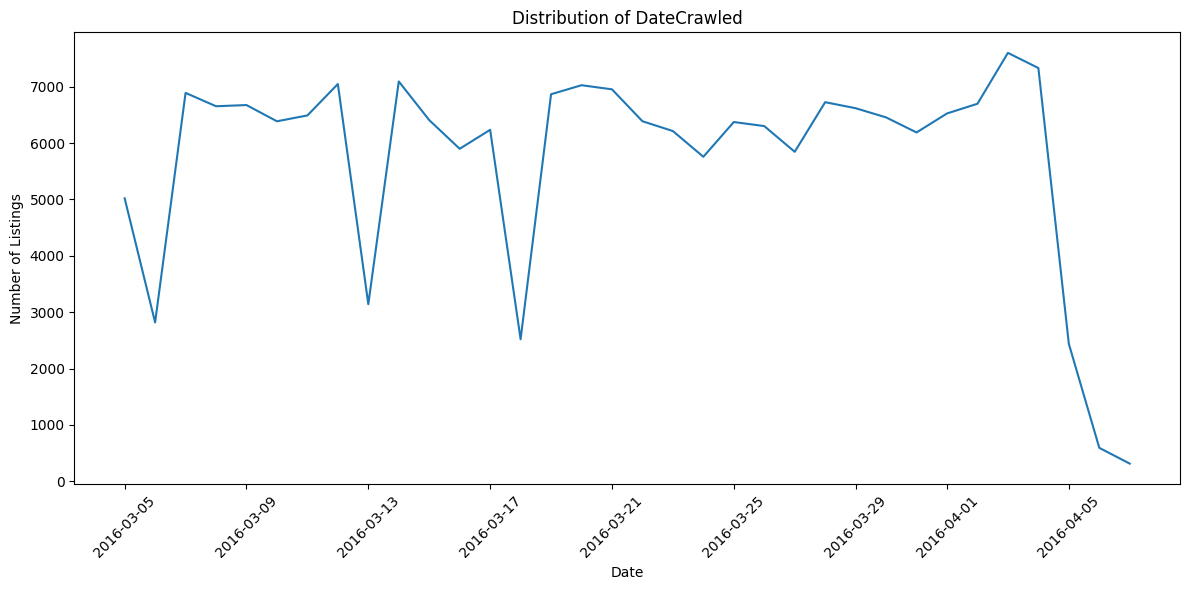

In [37]:
# Group by date only (ignoring time) and count
date_counts = X_train['DateCrawled'].dt.date.value_counts().sort_index()

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(x=date_counts.index, y=date_counts.values)
plt.title("Distribution of DateCrawled")
plt.xlabel("Date")
plt.ylabel("Number of Listings")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


For most of the range, the number of listings is consistent except for a few dates where the graph has a dip. It is not particularly clear why the dips exist, perhaps on weekend days when there are not people working on the database? The data does not indicate a specific reason. Let's view a graph between these dates and car prices to see if any kind of pattern appears.

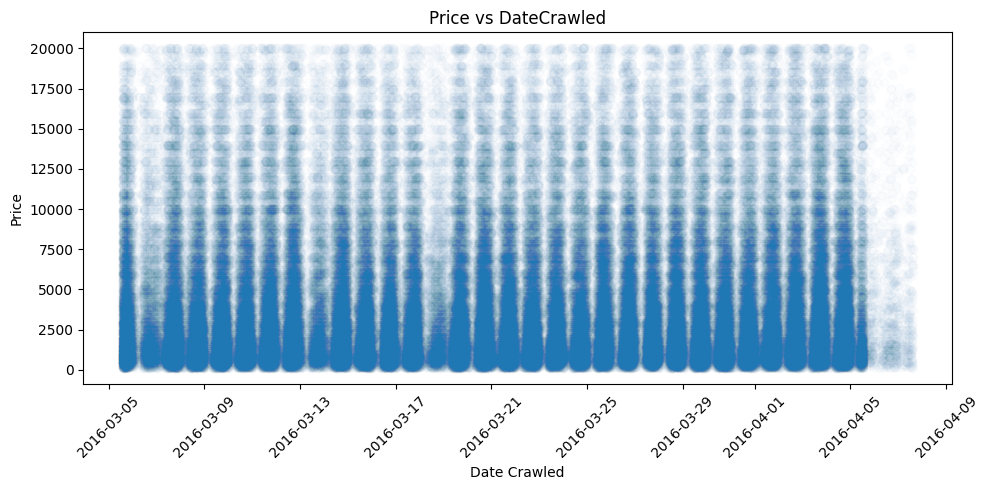

In [38]:
plt.figure(figsize=(10, 5))
plt.scatter(X_train['DateCrawled'], y_train, alpha = 0.01)
plt.xlabel('Date Crawled')
plt.ylabel('Price')
plt.title('Price vs DateCrawled')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Clearly there is no particular trend between Date Crawled and car price, even with a low alpha value. Let's check the average car prices over crawl dates to see if something more obvious appears.

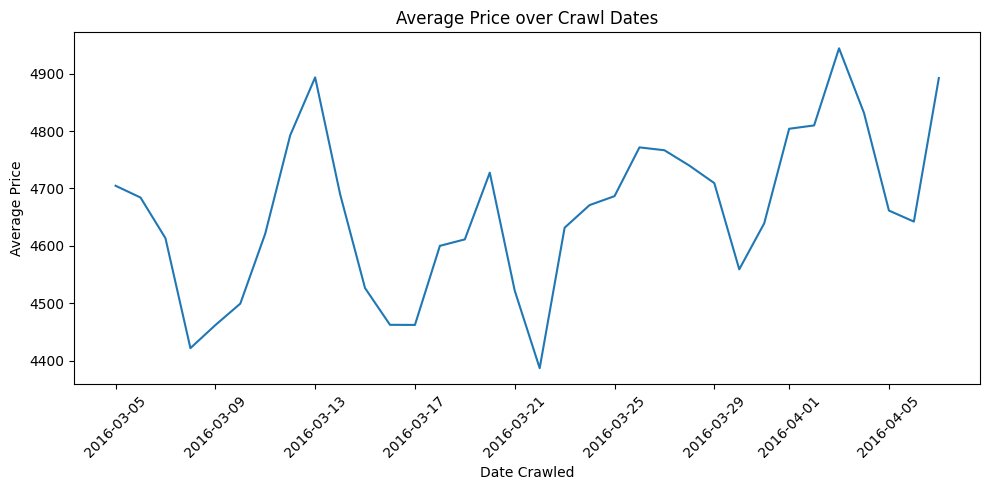

In [39]:
# Combine into one DataFrame
df_temp = X_train.copy()
df_temp['Price'] = y_train

# Average price per day
avg_price_per_day = df_temp.groupby(df_temp['DateCrawled'].dt.date)['Price'].mean()

# Plot
plt.figure(figsize=(10, 5))
avg_price_per_day.plot()
plt.xlabel('Date Crawled')
plt.ylabel('Average Price')
plt.title('Average Price over Crawl Dates')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Once again, the average prices appear to fluctuate over crawl dates, but there is certainly no clear upward or downward trend. The market car price does not seem to change in the short time window. Let's use the non-parametric Kruskal-Wallis test to see if there are significant differences in prices across crawl dates.

In [40]:
# Attach price to X_train for grouping
df_dates = X_train.copy()
df_dates['Price'] = y_train

# Group prices by DateCrawled
prices_by_date = [group['Price'].values for _, group in df_dates.groupby('DateCrawled')]

# Perform Kruskal-Wallis test
stat, p_value = stats.kruskal(*prices_by_date)

print("Kruskal–Wallis H-statistic:", stat)
print("p-value:", p_value)

# Interpretation
if p_value < 0.05:
    print("Significant differences in prices across crawl dates.")
else:
    print("No statistically significant differences in prices across crawl dates.")

Kruskal–Wallis H-statistic: 15558.820734559951
p-value: 1.7020580494113923e-12
Significant differences in prices across crawl dates.


We see that our intuition at the beginning was potentially erroneous. We have a very low p-value, which indicates that there are significant differences in prices across crawl dates. Perhaps we can look at the top 10 dates by frequency and see if we can graphically confirm this finding.

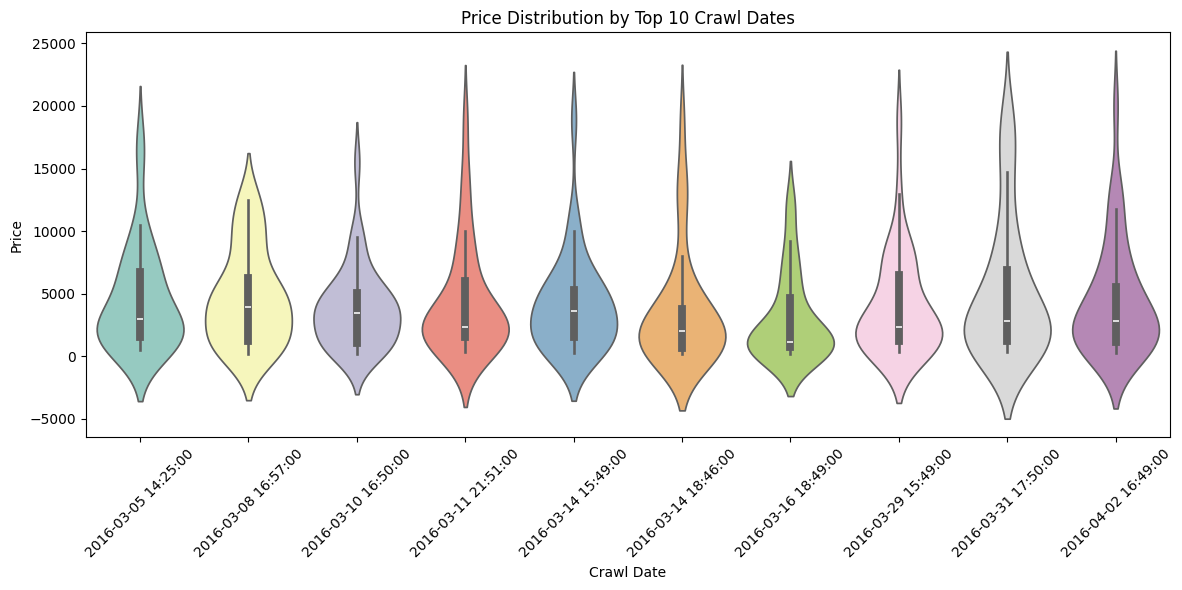

In [41]:
# Attach Price for plotting
df_dates = X_train.copy()
df_dates['Price'] = y_train

# Get top 10 dates by frequency
top_dates = df_dates['DateCrawled'].value_counts().nlargest(10).index
df_top_dates = df_dates[df_dates['DateCrawled'].isin(top_dates)]

# Sort by date for better readability
df_top_dates = df_top_dates.sort_values(by='DateCrawled')

# Create violin plot
plt.figure(figsize=(12,6))
sns.violinplot(data=df_top_dates, x='DateCrawled', y='Price', order=sorted(top_dates), palette='Set3', hue='DateCrawled', legend=False)
plt.xticks(rotation=45)
plt.title('Price Distribution by Top 10 Crawl Dates')
plt.xlabel('Crawl Date')
plt.ylabel('Price')
plt.tight_layout()
plt.show()


By visualizing the top 10 crawl dates, we see that each crawl date has high variability, high-priced outliers, and considerable overlap with other distributions. We also see that some of the dates have noticeably wider distributions and more high-priced listings. It is likely that these differences could demonstrate changes in the mix of vehicles listed different days, data collection patterns, et cetera. Our statistical testing and visual analysis suggests that crawl date has a particular effect on car prices, but is certainly not a dominant factor.

During our preprocessing or encoding, DateCrawled will be transformed into a single numeric variable, which will represent the number of days since the earliest crawl date. This is chosen for several reasons: Extracting the year from each date is pointless since the entire time interval is in the same year. There are only two months in this time frame that extracting it would also be unhelpful. The days since the earliest date could be useful since there are several entries in this column, and it should maintain potential chronological trends without introducing high-cardinaltiy categorical variables or overfitting risks.

## Analysis on VehicleType

Intuitively, the type of vehicle should be a great factor in dictating the price of a car. Here is some general information about the column.

In [42]:
#General information
print("General info:\n")
print(X_train['VehicleType'].info())
print("")

#Statistical information
print("Statistical info:\n")
print(X_train['VehicleType'].describe())
print()

#Number of null values in VehicleType
vehicle_type_nulls = X_train['VehicleType'].isnull().sum()
print(f'Number of null values: {vehicle_type_nulls}')
print(f'Percentage of null values: {vehicle_type_nulls / X_train.shape[0] * 100:.2f}%')

#Realtive frequency of 'Sedan' value
sedan_occurences = (X_train['VehicleType'] == 'sedan').sum()
sedan_relative_frequency = (sedan_occurences / X_train.shape[0]) * 100
print(f'Percentage of sedan occurences: {sedan_relative_frequency:.2f} %')


General info:

<class 'pandas.core.series.Series'>
RangeIndex: 194503 entries, 0 to 194502
Series name: VehicleType
Non-Null Count   Dtype 
--------------   ----- 
178093 non-null  object
dtypes: object(1)
memory usage: 1.5+ MB
None

Statistical info:

count     178093
unique         8
top        sedan
freq       51868
Name: VehicleType, dtype: object

Number of null values: 16410
Percentage of null values: 8.44%
Percentage of sedan occurences: 26.67 %


A few things to note: We have 16410 null values out of 194503 total. This makes up roughly 8.44% of the data so removing all of these values is not ideal so imputing them with a particular value is what we will likely do in the preprocessing of the this column. We also see that 'sedan' is the most common vehicle type in our column, showing up 51868 times which comprising 26.67% of all the values. It is possible that we may impute the null values with 'sedan' since it is the mode, but we will explore more about this column before making a decision. Also note that there are 8 unique values, which is a low cardinality. When we have to encode, we can use one-hot encoding for our linear models because it will not blow up our dataframe, and we can use label encoding for our tree models since it will keep a low cardinality and should perform just fine given the nature of tree models.

Let's view a distribution for this column.

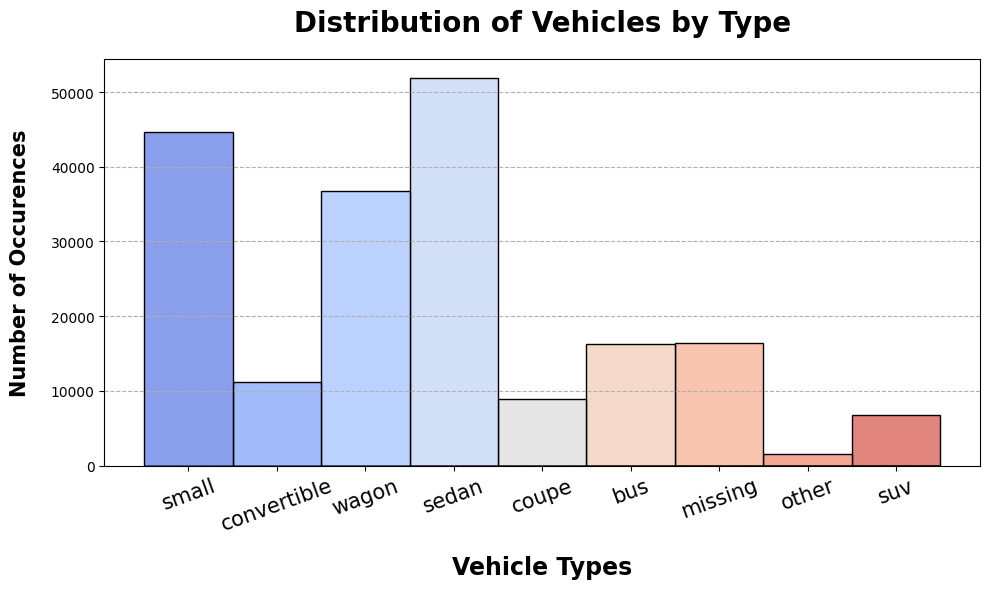

In [43]:
#Copy of the dataframe so that we can see null values in the histogram
X_train_missing = X_train.copy(deep = True)
X_train_missing['VehicleType'] = X_train_missing['VehicleType'].fillna('missing')

#Plot figure
plt.figure(figsize=(10,6))
sns.histplot(data=X_train_missing, x= 'VehicleType', edgecolor = 'black', alpha = 0.7, palette='coolwarm', hue='VehicleType', legend = False)

#Plot settings
plt.title("Distribution of Vehicles by Type", fontsize = 20, fontweight = 'bold', pad = 20)
plt.xlabel("Vehicle Types", fontsize = 17, fontweight = 'bold', labelpad = 15)
plt.xticks(rotation = 20, fontsize = 15)
plt.ylabel("Number of Occurences", fontsize = 15, fontweight = 'bold', labelpad=15)
plt.grid(axis='y', linestyle='--', alpha=1)
plt.tight_layout()
plt.show()

Observing the graph, we see that 'sedan', 'small', and 'wagon' vehicle types dominate in terms of frequency. Thus, imputing all 'missing' values with the 'sedan', the mode, would only add the dominance of the sedan type. This could lead to misleading conclusions by artificially increaseing sedan counts and possibly introducing patterns that do not exist. We could also be pairing vehicle types with vehicle brands that do not possess such vehicle types--leading to misleading inputs to train our model with. Therefore, since the null values contribute a considerable portion of our data and we do not wish to impute them with the mode, we will impute all of the null values into their own category, 'missing', as we did above in our graph. This gives more accurate data in terms of actual existing cars, as well as, a way to interpret null values that can still be used in the training of our model. These changes will be made in the preprocessing of our data.

## Analysis on Registration Year

It is intuitive that Registration Year of a car would matter in the determination of a car's worth. Generally speaking, older cars tend to have less in value. Of course, there are exceptions to this with classic cars or other exotic car makes; however, this is not typically the case. Let's explore the data to see if it follows this intuition or not.

In [44]:
#General information
print("General info:\n")
print(X_train['RegistrationYear'].info())
print("")

#Statistical information
print("Statistical info:\n")
print(X_train['RegistrationYear'].describe())
print()

#Number of null values in VehicleType
registration_year_nulls = X_train['RegistrationYear'].isnull().sum()
print(f'Number of null values: {registration_year_nulls}')
print(f'Percentage of null values: {registration_year_nulls / X_train.shape[0] * 100:.2f}%')

#Number of unique values
registration_year_unique = X_train['RegistrationYear'].nunique()
print(f'Number of unique registration years: {registration_year_unique}')

#Realtive frequency of 'Sedan' value
#sedan_occurences = (X_train['registration_year_nulls'] == 'sedan').sum()
#sedan_relative_frequency = (sedan_occurences / X_train.shape[0]) * 100
#print(f'Percentage of sedan occurences: {sedan_relative_frequency:.2f} %')

General info:

<class 'pandas.core.series.Series'>
RangeIndex: 194503 entries, 0 to 194502
Series name: RegistrationYear
Non-Null Count   Dtype
--------------   -----
194503 non-null  int64
dtypes: int64(1)
memory usage: 1.5 MB
None

Statistical info:

count    194503.000000
mean       2003.760163
std          54.253230
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: RegistrationYear, dtype: float64

Number of null values: 0
Percentage of null values: 0.00%
Number of unique registration years: 112


We observe that this column contains some irregular values, which likely result form data entry data errors and do no align with valid categories. Values such as 9999 and 1000 clearly do not make sense since these years represent the registration year of vehicles. Vehicles did not exist in 1000 and 9999 has not occured yet so filtering in the preprocessing will certainly need to be executed. We observe that there are no null values present in this column so that is taken care of. We also observe that the number of unique values is 112, which means that encoding techniques such as one-hot encoding is no longer an option since the cardinality would blow up. 

Let's visualize the distribution of the data to see if we observe any other characteristics.

RegistrationYear
2000    12632
1999    12491
2005    12272
2006    11512
2003    11389
2001    11272
2004    11208
2002    10701
2007     9877
1998     9682
Name: count, dtype: int64


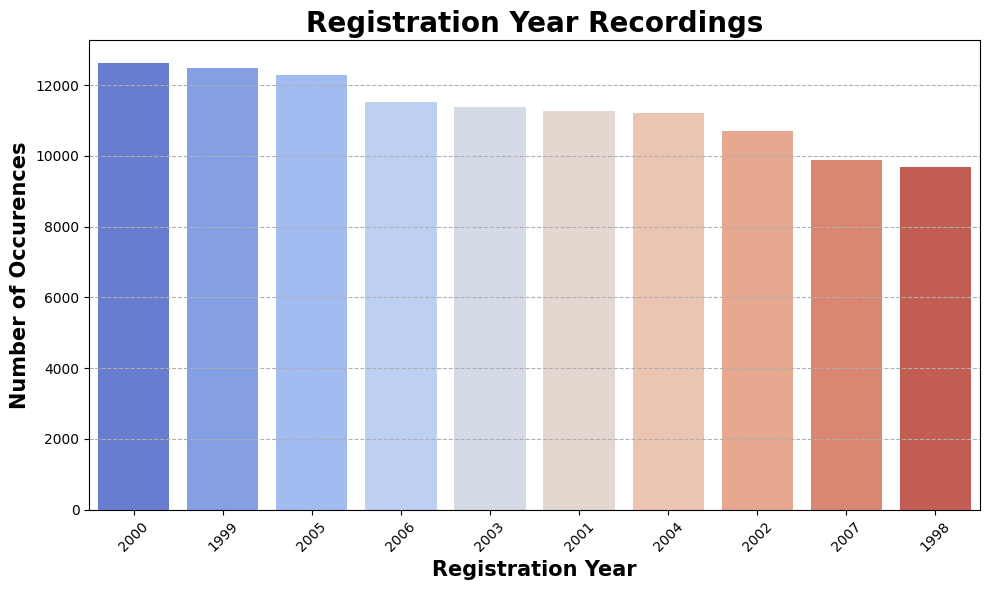

In [63]:
#Top 10 values
registration_year_top_10 = X_train['RegistrationYear'].value_counts(ascending = False).nlargest(10)
print(registration_year_top_10)

#Figure 
plt.figure(figsize=(10,6))
sns.barplot(x=registration_year_top_10.index.astype(str), y=registration_year_top_10.values, palette='coolwarm', hue=registration_year_top_10.index.astype(str), alpha = 1)

#Figure specs
plt.title("Registration Year Recordings", fontsize = 20, fontweight = 'bold')
plt.xlabel("Registration Year", fontsize = 15, fontweight ='bold')
plt.xticks(rotation = 45)
plt.ylabel("Number of Occurences", fontsize = 15, fontweight = 'bold')
plt.grid(axis='y', linestyle='--', alpha = 1)

#Results
plt.tight_layout()
plt.show()


## Analysis on Gearbox

## Analysis on Power

## Analysis on Model

## Analysis on Mileage

## Analysis on Registration Month

Let's check the first few entire of our registration month column.

In [46]:
print(formatted_df['RegistrationMonth'].head(10))

KeyError: 'RegistrationMonth'

Though registration year could certainly affect the pricing of a car, the month may not have as great of an impact. Let's check to see the correlation between the month feature and the pricing of a car. If the correlation is low, we will drop this column and not use it as a feature.

In [ ]:
#Since the many missing entries '0', we need to replace those with null values and drop them to find the pearson correlation

#Make a copy of our dataframe for testing
correlation_test_df = formatted_df.copy(deep = True)

#Replacing the 0's with null values
correlation_test_df['RegistrationMonth'] = correlation_test_df['RegistrationMonth'].astype('Int64').replace(0, pd.NA)

#Calculating the correlation between registration month and vehicle pricing; we drop any row that contains a null registration month for more accurate results
correlation = correlation_test_df[['RegistrationMonth', 'Price']].dropna().corr().loc['RegistrationMonth', 'Price']

#Result
correlation

We see that there is a weak positive correlation between registration month of a car and it's value. Let's take a look at the distribution.

In [ ]:
#Scatterplot to see what visual correlation is between registration month and price
sns.scatterplot(data=formatted_df, x = 'RegistrationMonth', y = 'Price')
plt.title('Registration Month vs Price')
plt.show()

Clearly, there is not a discernable pattern here. This is likely due to the fact that this is a categorical column and there are many values per category. Let's visualize the distribution using a boxplot for each category. This may help to see a particular pattern.

In [ ]:
sns.boxplot(data=formatted_df, x='RegistrationMonth', y='Price')
plt.title('Registration Month vs Price')
plt.show()

Once again, there's no discernable correlation between registration month and target. They all have relatively similar quartiles and medians, as well a, similar clusters of outliers. We do have a column of 'month 0', which is likely a typo or a placeholder for null values. Imputing these this categoriy with the mode would likely not change anything--except for the mode itself. Therefore, we can safely drop this column so that we do not use it as a feature in the training and testing of our models.

## Analysis on FuelType

## Analysis on Brand

## Analysis on NotRepaired

## Analysis on DateCreated

## Analysis on PostalCode

## Analysis on LastSeen

# Preprocessing of the Data

Now that we have split our data, we can perform data changes such as imputation of null values for all datasets (prevents data leakage), removing duplicates rows and/or columns for the training dataset only (improves to model genearlization), removing outliers of the training data only (improves model genearlization), apply transformations (e.g. log transformation) to all datasets, remove potential features for all datasets, and potentially more.

## Helper Functions for Data Formatting

The functions in this section will be used for data formatting, essentially keeping our code as neat as possible.

In [ ]:
#This function imputes null values of all the datasets with the mean of the training data--avoiding data leakage
def impute_column_with_training_mean(X_train, X_valid, X_test, column_name):
    #We ensure that the column exists and is numeric
    if column_name not in X_train.columns:
        raise ValueError(f"Column {column_name} does not exist in the training data.")
    
    #We also ensure that the column is numeric
    if not pd.api.types.is_numeric_dtype(X_train[column_name]):
        raise TypeError(f"Column {column_name} is not numeric.")
    
    #Now we fit the imputer to the training data
    imputer = SimpleImputer(strategy='mean')
    imputer.fit(X_train[[column_name]])

    # Transform the column in all datasets
    X_train_imp = pd.concat([X_train.drop(columns=[column_name]), pd.DataFrame(imputer.transform(X_train[[column_name]]), columns=[column_name], index=X_train.index)], axis=1)

    X_val_imp = pd.concat([X_valid.drop(columns=[column_name]), pd.DataFrame(imputer.transform(X_valid[[column_name]]), columns=[column_name], index=X_valid.index)], axis=1)

    X_test_imp = pd.concat([X_test.drop(columns=[column_name]), pd.DataFrame(imputer.transform(X_test[[column_name]]), columns=[column_name], index=X_test.index)], axis=1)

    return X_train_imp, X_val_imp, X_test_imp


#THis function allows you to impute a particular value in a column with the mean of the training data to all datasets
def replace_value_with_training_mean(X_train, X_val, X_test, column, bad_value):
    #Here we calculate the mean of our specific column from the training data excluding the value that we are going to replace, since it represents a placeholder
    valid_mean = X_train.loc[X_train[column] != bad_value, column].mean()

    #Here we replace the bad value with the mean in all datasets
    X_train[column] = X_train[column].replace(bad_value, valid_mean)
    X_val[column]   = X_val[column].replace(bad_value, valid_mean)
    X_test[column]  = X_test[column].replace(bad_value, valid_mean)

    return X_train, X_val, X_test


## Checking the Years for Registration Year of Vehicle

Let's take a look at the general information about the RegistrationYear column.

In [ ]:
#General information about the Power column in our X_train dataset
print(X_train['RegistrationYear'].info())

As a quick check, our data type is appropriate and there are no null values.

Let's see all of the unique registration year values we have in our dataset—-assuming it is not too large.

In [ ]:
#Printing the unique registration years from earliest to latest
print(X_train['RegistrationYear'].sort_values(ascending=False).unique())

There are a few reasons why many of these values will serve as neither good training nor testing data. First, we have recorded time periods where automobiles did not exist, e.g., 1000 AD. Secondly, we have particular years that have not occured yet; for example, the year 9999 AD is past the current year by several millenia. Therefore, we are going to have to remove the rows that do not fit well for our model. In addition to our filtering, classic cars (for this project, cars registered by 1990) will also be removed. Classic cars are often priced differently than typical newer cars in today's time. Therefore, to achieve better pricing predictions for relatively modern cars with standard pricing methods, we will filter our classic cars.

In [ ]:
#First we define a mask to filter out the invalid entries --> this ensures that X_train and y_train have the same indexes
mask = (X_train['RegistrationYear'] >= 1990) & (X_train['RegistrationYear'] <= 2019)

#Now we can filter X_train and y_train using the mask
X_train = X_train[mask].reset_index(drop=True)
y_train = y_train[mask].reset_index(drop=True)

Let's check to see if the changes were made.

In [ ]:
print(X_train['RegistrationYear'].sort_values(ascending=False).unique())

Our filtering was successful where we have a range of registration years from 1990 to 2019. Note that this filter is applied to the training data only so that we can observe how our model handles testing data, which could have outliers within it.

## Inspecting Power Values

Let's see the general statistics for the power feature in our data.

In [ ]:
print(X_train['Power'].info())

In [ ]:
print(X_train['Power'].describe())

Let's also see what the values of power are in the training data.

In [ ]:
print(X_train['Power'].value_counts(dropna=False).sort_values(ascending=False))

There are values of horsepower (HP) that are not realistic values. Observing the max value of 19312 and a minimum value of 0, these are likely typos, glitches, missing entries, or something related. We also observe that we have a wide spread of values since our standard deviation of 187, which is not a sensible spread for most cars. Also, 300 HP for a car is a high value compared to most everyday cars. Moreover, in terms of sports cars, values can range from 300 - 600 on average. Let's set the maximum HP to 600 for our power feature.

In [ ]:
#Here's our filtering (mask) that we will apply to both X_train and y_train --> ensuring we keep indexes aligned --> useful for potential future analysis
mask = X_train['Power'] <= 600

# Apply to both X_train and y_train
X_train = X_train[mask].reset_index(drop=True)
y_train = y_train[mask].reset_index(drop=True)


#Let us observe the general statistics now
print(X_train['Power'].describe())

We lost a fraction of our data after the removal of any row with horsepower greater than 600. Our mean dropped by 3 points roughly and our standard deviation improved considerably. However, we still have a minimum value of 0. Before we observe the distribution of the power feature, let's see the frequency of our top values to get a numerical sense of what is going on.

In [ ]:
print(X_train['Power'].value_counts())

Clearly we have multiple data points whose horsepower is zero. Removing the rows with this HP would remove more data than ideal so we need to impute the data with a central tendency, likely the mean or medium. Let's take a look at the distribution to see if we should impute the column with.

In [ ]:
#Setting up the plot
plt.figure(figsize=(12, 6))
sns.histplot(X_train['Power'], bins=50, kde=True)
plt.title('Distribution of Power (Horsepower) for Values Between 1 and 600')
plt.xlabel('Horsepower')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

There are outliers for this particular distribution, which could disrupt the positioning of the mean. To see the best choice for imputation, we will replace the 0's of our power feature with both the mean and median of our data and see which imputation has the least impact on the distribution.

In [ ]:
#We will use these copies to compare the statistics of the mean and median imputation
mean_df, median_df = [X_train.copy(deep=True) for _ in range(2)]

#First, let us replace all of the zeros with null values; we can do this since there are no null values within this column
mean_df['Power'] = mean_df['Power'].replace(0, np.nan)
median_df['Power'] = median_df['Power'].replace(0, np.nan)

#Imputing null values with mean and median
mean_df['Power'] = mean_df['Power'].fillna(mean_df['Power'].mean())
median_df['Power'] = median_df['Power'].fillna(median_df['Power'].median())

#Now let's see some of the stats for these copies
print(mean_df['Power'].describe())
print(median_df['Power'].describe())

Regardless of whether the data is imputed by the mean or median, the values are roughly the same, even for the mean itself. Thus, choosing either value to use is fine. We'll inspect the distributions just to be sure.

In [ ]:
#Setting up the plot figure
plt.figure(figsize=(12, 6))

#Plotting the mean-imputed data
plt.subplot(1,2,1)
sns.histplot(mean_df['Power'], bins = 50, color='skyblue')
plt.title('Distribution using Mean Imputation')
plt.xlabel('Power')
plt.ylabel('Frequency')

#Plotting the median-imputted data
plt.subplot(1,2,2)
sns.histplot(median_df['Power'], bins=50, color='salmon')
plt.title('Distribution using Median Imputation')
plt.xlabel("Power")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

Since the distributions are virtually the same, imputing the power column with the mean from the training data to all datasets will work well and avoid data leakage.

In [ ]:
#Here we impute the null values of the Power column in all datasets with the mean of the training data to avoid data leakage
X_train, X_val, X_test = replace_value_with_training_mean(X_train, X_valid, X_test, 'Power', 0)

Let's check the statistics of the power column just to be sure the changes were made.

In [ ]:
print("==========Imputed Power column stats:==========\n")
print("X_train stats:")
print(X_train['Power'].describe())
print("")

print("X_valid stats:")
print(X_valid['Power'].describe())
print(" ")

print("X_test stats:")
print(X_test['Power'].describe())

We see that the changes were properly executed.

## Replacing Categorical Features with Mode

Here are the first few entries of our categorical feature that we are likely going to use with our model later.

In [ ]:
#A list of our categorical columns
categorical_features = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'NotRepaired']

#Here are some of the values in our categorical columns
print(X_train[categorical_features].head(5))

Let's see the number of null entries in these columns.

In [ ]:
print(X_train[categorical_features].info())

Since we are working with categorical columns that contain thousands of null entries, we need to impute them with their corresponding modes.

In [ ]:
#This for loop will impute the mode for the null values in each respective feature
for feature in categorical_features:
    if X_train[feature].isnull().sum() > 0:
        mode = X_train[feature].mode()[0]
        X_train[feature] = X_train[feature].fillna(mode)
        X_val[feature]   = X_val[feature].fillna(mode)
        X_test[feature]  = X_test[feature].fillna(mode)

Let's check to ensure that there we have only valid entries in our categorical columns.

In [ ]:
print("X_train categorical features info:\n")
print(X_train[categorical_features].info())
print("")

print("X_valid categorical features info:\n")
print(X_valid[categorical_features].info())
print("")

print("X_test categorical features info:\n")
print(X_test[categorical_features].info())

## Checking Mileage Values

Let's check the first few values in our Mileage column and general information about it.

In [ ]:
#First 10 values of the mileage column
print("First 10 values of the Mileage column:\n")
print(X_train['Mileage'].head(10))

print()
print("=======================================================")
print()

#General information about the Mileage column
print("General information about the Mileage column:\n")
print(X_train['Mileage'].info())

We see that there are no null values in the Mileage column. Now let's check the unique values of the Mileage column.    

In [ ]:
#Here we check the unique values of the Mileage column
print(X_train['Mileage'].value_counts(ascending=False))

Mileage is often a significant factor in the value of the car. Typically, as a car gradually increases in mileage, its overall value begins to decrease. However, since we have only few unique mileage values, it will be difficult to compute a Pearson correlation from it. However, we will still compute the correlation to see if we have a negative correlation (indicating an incrase in mileage decreases value) and plot the distribution to see a visual between mileage and car price (though the graph will likely be of little usage).

In [ ]:
#Computing the linear correlation between the Mileage and Price columns
correlation = X_train['Mileage'].corr(y_train)

#Results
print(correlation)

We do have a negative correlation, which is expected since the increase of mileage of a car typically decreases the value of the car. Let's see a visualization of mileage vs price to see if we can discern any particular pattern whatsoever.

In [ ]:
#Scatterplot setup
plt.figure(figsize=(10,6))
sns.scatterplot(x=X_train['Mileage'], y=y_train, hue=X_train['Mileage'], palette='husl', alpha=0.01, legend=False)

#Overlaying a regression line to show the trend
sns.regplot(x=X_train['Mileage'], y=y_train, scatter=False, line_kws={'color':'black', 'linewidth': 3, 'linestyle':'dashed'})

#Extra plot specifications
plt.title("Mileage vs Price by Brand with Trendline", fontsize=16, weight='bold')
plt.xlabel('Mileage', fontsize=20)
plt.ylabel('Price', fontsize=20)

#Footnote at the bottom of the plot
plt.figtext(0.5, -0.05, 'The trendline implies that higher mileage cars have lower car prices.', horizontalalignment='center', fontsize=12, wrap=True, fontstyle='italic', color='gray')

#Results
plt.tight_layout()
plt.show()

Clearly the negative slope of our trendline matches the negative sign of our pearon correlation value of -0.34. Indicating that higher mileage cars have a lower value in general. Let's see what values that this columns acquires.

In [ ]:
#Printing the unique values of the Mileage column
print("Unique values of the Mileage column:\n")
print(X_train['Mileage'].value_counts(dropna=False))

It appears that mileage recordings are rounded off. Moreover, due to the large frequency of cars with 150000 miles, this is likely a mileage cap that Rusty Bargain implemented. Let's check to see the distribution of this column for a visualization and calculate it skewness to ensure we do not need a transformation of some kind.

In [ ]:
#Setting the background
sns.set(style='whitegrid')

#Establishing the figure
plt.figure(figsize=(10,6))
sns.countplot(x=X_train['Mileage'], hue = X_train['Mileage'], palette='deep', legend=False)

#Adding labels
plt.xticks(rotation=45, fontsize=12)
plt.xlabel("Mileage", fontsize=20)
plt.ylabel("Number of Cars", fontsize=20)
plt.title("Distribution of Mileage for Rusty's Used Cars", fontsize=16, weight='bold')
plt.tight_layout()
plt.show()

In [ ]:
#Skewness of distribution
print(X_train['Mileage'].skew())

The skewness is calculated as -1.75, which is demonstrated by our graph. There's nothing to impute so our feature will remain the same unless we scale it later, which could be important for linear regression.

## Checking Price (Target) Values

Let's check the first few entries of our target column (Price --> tree models only).

In [ ]:
#First few entires of the price column
print(y_train.head(10))

Let's see the general statistics for this column.

In [ ]:
#General statistics for our target
print(y_train.describe())

We see that the minimum price of cars is 0, which is likely a typo or some kind of null entry. It would be ideal to filter the price of vehicles to something more realistic, 100 for example. We will check the sum of relative frequencies of prices from 0 - 99 to ensure we do not lose too much data. In addition, the price column has a mean of 4408 and a median of 2700, indicating that we have heavy outliers that are pulling the mean to be bigger than the median. This suggests that our distirbution is skewed right. The spread of this data is also considerable because our standard deviation is 4504. 

Let's check the sum of relative frequences of prices ranging from 0 - 99 so that we may know if it is safe to remove rows in our dataframe that contain any of these prices.

In [ ]:
#This is the number of entries in our training target (y_train)
price_entries = len(y_train)

#We filter the y_train to only include prices ranging from 0 - 99
filtered_prices_series= y_train[(y_train >= 0) & (y_train < 100)]

#This is the number of rows that y_train contains. This is used to calculate the relative frequency.
number_rows_filtered_prices = filtered_prices_series.shape[0]

#Relative frequency calculation
relative_frequency = number_rows_filtered_prices / price_entries

#Result
print(relative_frequency)

The prices ranging from 0 - 99 only compromise of roughly 4% of the data. Therefore, we are going to filter out these prices values so that we get an accurate depiction of our distribution when we graph it.

In [ ]:
#Since we are going to filter y_train, the indexes will change, so we also need to account for this in X_train. Thus we create a mask.
mask = y_train >= 100

#Now we filter both X_train and y_train using the mask
X_train = X_train[mask].reset_index(drop=True)
y_train = y_train[mask].reset_index(drop=True)

Let's ensure that changes took place and then we can visualize our distribution.

In [ ]:
print(y_train.describe())

Let's take a look at the distribution of values in this target and calculate skewness.

In [ ]:
plt.figure(figsize=(10,6))
sns.histplot(data=y_train, bins=50, kde=False, color='skyblue')

plt.title('Histogram of Car Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
print(y_train.skew())

Since our distribution has a skewness of 1.41 and our graph is visually skewed to the right, a log transformation will be implemented since we are using linear regression in our models later on. This helps with the normality assumption with linear regression.

In [ ]:
zero_count_valid = (y_valid == 0).sum()
print(f"Number of zero entries in y_valid: {zero_count_valid}")

zero_count_test = (y_test == 0).sum()
print(f"Number of zero entries in y_test: {zero_count_test}")

print(y_valid.info())
print(y_test.info())

In [ ]:
#We have to disccard zeros for y_valid and y_test so we are using the log transformation

#Creating a mask to filter out zeros in y_valid and y_test
mask_valid = y_valid > 0
mask_test = y_test > 0

#Now we filter both X and y sets accordingly
X_valid = X_valid[mask_valid].reset_index(drop=True)
y_valid = y_valid[mask_valid].reset_index(drop=True)

X_test = X_test[mask_test].reset_index(drop=True)
y_test = y_test[mask_test].reset_index(drop=True)   

#Log transformation of our prices --> we need to do this for all target series'
y_train_log = np.log(y_train)
y_valid_log = np.log(y_valid)
y_test_log = np.log(y_test)

Now let's compare the distibutions visually and calculate the skewness of the log distribution.

In [ ]:
plt.figure(figsize=(14, 5))

# Original Price Distribution
plt.subplot(1, 2, 1)
sns.histplot(data=y_train_log, bins=50, kde=True, color='steelblue')
plt.title('Original Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')

# Log-Transformed Price Distribution
plt.subplot(1, 2, 2)
sns.histplot(data=y_train, bins=50, kde=True, color='darkorange')
plt.title('Log-Transformed Price Distribution')
plt.xlabel('Log(Price)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [ ]:
#Skewness before log transformation
print("Skewness of original prices:", y_train.skew())
print("")

#Skewness of log prices
print("Skewness of log prices:", y_train_log.skew())

We now see that our skewness has decreased from 1.41 to -0.32, a good improvement for us when we have to train a linear regression model later. Note that LogPrice will not be the target for our tree model.

## Checking Duplicate Rows in Entire Dataframe

Up to this point, we have inspected each column individually for null values / invalid data entries, which were handled using removal of data or imputation. Now we need to check to see if there are any duplicated rows in entire dataframe because there should not be any. If there are, we will remove them.

In [ ]:
#Here are the number of duplicated rows we have in our dataframe. This will be used for boolean indexing next
duplicated_rows = X_train.duplicated().sum()

#Here we see the first few duplicated rows, if there are any
X_train[X_train.duplicated()].head(15) if duplicated_rows > 0 else None

Clearly we have several duplicates that need to be dropped. Of course the first instances will be kept, but any copies will be deleted.

In [ ]:
#Since we are going to drop duplicates, we have to modify both X_train and y_train. Thus, we need to create a mask.
mask = ~X_train.duplicated(keep='first')

#Now we can filter both X_train and y_train using the mask
X_train = X_train[mask].reset_index(drop=True)
y_train = y_train[mask].reset_index(drop=True)
y_train_log = y_train_log[mask].reset_index(drop=True)

Let's ensure that the change was made.

In [ ]:
#The sum of duplicates in X_train and y_train
print("Number of duplicates in X_train after dropping duplicates:")
print(X_train.duplicated().sum())


## Checking Duplicate Values in Each Column

For this section, we are going to check the number of duplicates and relative frequency of duplicates for each column. Due to what the data represents, it is reasonable that most of the columns have a large number of duplicates. Though we are not going to format anything regarding duplicate values for these columns, this information could be helpful in our EDA.

In [ ]:
#Here is the length of the dataframe --> used to calculate relative frequency in the denominator
X_train_length = len(X_train)

#Here is a dictionary that we are going to store the name of the columns with their total duplicates and relative frequency of duplicates
duplicates_dict = {}

for column in X_train.columns:
    #This is the number of duplicates we have in the respective column
    number_of_duplicate_values = X_train[column].duplicated().sum()

    #This is relative frequency of duplicates
    relative_frequency = (number_of_duplicate_values / X_train_length) * 100

    #This is the number of unique values that each columns has
    number_unique_values = X_train[column].nunique()

    #Store the results in our dictionary
    duplicates_dict[column] = {'Number of Duplicates': int(number_of_duplicate_values), 'Relative Frequency': float(round(relative_frequency, 2)), 'Unique Values': int(number_unique_values)}

#This is our dataframe that we can display the dictionary contents nicely
duplicates_df = pd.DataFrame.from_dict(duplicates_dict, orient='index')

#Here are the results
duplicates_df

# Creating Linear and Tree Based Datasets

Now that we have most of the editing completed in our datasets (except for scaling --> performed during the validation of our models) we need to split up our datasets into sets that are going to be explicitly used for linear models and tree-based models. This is particularly helpful with the encoding of features demonstrated in the next section.

Recall that these are the datasets that we have created thus far:

 - X_train
 - X_valid
 - X_test

 - y_train
 - y_valid
 - y_test
 
 - y_train_log
 - y_valid_log
 - y_test_log

In [ ]:
"""These are the datasets used strictly for our linear models"""

#Features for linear models
X_train_linear = X_train.copy(deep=True)
X_valid_linear = X_valid.copy(deep=True)
X_test_linear = X_test.copy(deep=True)

#Targets for linear models
y_train_linear = y_train.copy(deep=True)
y_valid_linear = y_valid.copy(deep=True)
y_test_linear = y_test.copy(deep=True)

#Log transformed targets for linear models
y_train_log_linear = y_train_log.copy(deep=True)
y_valid_log_linear = y_valid_log.copy(deep=True)
y_test_log_linear = y_test_log.copy(deep=True)


"""These are the datasets used strictly for our tree-based models"""
#Features for tree-based models
X_train_tree = X_train.copy(deep=True)
X_valid_tree = X_valid.copy(deep=True)
X_test_tree = X_test.copy(deep=True)

#Targets for tree-based models
y_train_tree = y_train.copy(deep=True)
y_valid_tree = y_valid.copy(deep=True)
y_test_tree = y_test.copy(deep=True)

Since tree models do not depend on assumptions like linearity, constant variance, or normal residuals, we will use the original target values.

# Encoding Categorical Columns

When we encode our categorical columns, we will need multiple dataframes that will be formatted depending on the model that we are going to train / test. For linear models, our dataframe will include one-hot, binary, and target / frequency encodings. For tree-based models, our dataframe will have binary and target/frequency encondings.

## Encoding DateCrawled, DateCreated, and LastSeen Columns

We are going to encode all of the datetine type columns by extracting the year for each columns. It is a broader measurement so it will likely be more useful for predictions.

In [ ]:
#Here are the columns that we are going to extract the year from
date_columns = ['DateCreated', 'LastSeen']

#This is a list of the dataframes that we are going to edit
year_extracted_dataframes = [X_train_linear, X_valid_linear, X_test_linear, X_train_tree, X_valid_tree, X_test_tree]

#This for loop will extract the year from the date columns and drop the original date columns
for dataframe in year_extracted_dataframes:
    for col in date_columns:
        dataframe[f'{col}_Year'] = dataframe[col].dt.year
        dataframe.drop(columns=[col], inplace=True)

Let's take a look at the results to see if the changes were made to the dataframes.

In [ ]:
#Results of the year extraction of the year_extracted_dataframes
for dataframe in year_extracted_dataframes:
    display(dataframe.head(3))

We see that the implementation of the new columns containing extracted years was successful.

## Encoding VehicleType and FuelType Columns

Let's check to see the numnber of unique values that VehicleType and FuelType have.

In [ ]:
#Unique values of VehicleType and FuelType
print("Unique values of VehicleType:\n")
print(X_train['VehicleType'].value_counts(dropna=False))
print("")
print("Unique values of FuelType:\n")
print(X_train['FuelType'].value_counts(dropna=False))


Since VehicleType has 8 unique values and FuelType has 7 unique values were neither have any ordering, one-hot encoding will be used for these column.

In [ ]:
#These are the columns that we are going to one-hot encode for our linear dataframes
one_hot_encode_columns = ['VehicleType', 'FuelType']   

#These are the columns that we are going to one-hot encode for our linear dataframes
ohe_columns = ['VehicleType', 'FuelType']

#These are the dataframes that we are going to one-hot encode
X_train_linear = pd.get_dummies(X_train_linear, columns=ohe_columns, drop_first=True, dtype=int)
X_valid_linear = pd.get_dummies(X_valid_linear, columns=ohe_columns, drop_first=True, dtype=int)
X_test_linear  = pd.get_dummies(X_test_linear,  columns=ohe_columns, drop_first=True, dtype=int)

#Just in case our validation or testing datasets are missing any columns that were in the training dataset, we will add those columns and fill them with zeros
X_valid_linear = X_valid_linear.reindex(columns=X_train_linear.columns, fill_value=0)
X_test_linear  = X_test_linear.reindex(columns=X_train_linear.columns, fill_value=0)


In [ ]:
#These are the columns that we are going to label encode
label_encode_columns = ['VehicleType', 'FuelType']

#Now we apply the label encoding to our tree-based datasets
for col in label_encode_columns:
    #initialize the label encoder
    le = LabelEncoder()
    #fitting the label encoder to the training data
    le.fit(X_train_tree[col])

    #transforming all datasets
    X_train_tree[col] = le.transform(X_train_tree[col])
    X_valid_tree[col] = le.transform(X_valid_tree[col])
    X_test_tree[col]  = le.transform(X_test_tree[col])

Even though we used Label Encoding for our tree-based dataframes, we may use target encoding with cross-validation to improve performance later.

Now let's check to make sure our changes were made.

In [ ]:
#This will make it easier to display the results by having both the names of the dataframes and the dataframes themselves
encoded_dataframes = {
    'X_train_linear': X_train_linear,
    'X_valid_linear': X_valid_linear,
    'X_test_linear': X_test_linear,
    'X_train_tree': X_train_tree,
    'X_valid_tree': X_valid_tree,
    'X_test_tree': X_test_tree
}

# Results
for name, dataframe in encoded_dataframes.items():
    print(f'\n{name}:')
    display(dataframe.head(3))


We see that the changes were successful.

## Encoding Gearbox Column

Since binary encoding is okay for both linear and tree based models, we are going to use binary encoding for the GearBox column and make the same changes to all dataframes.

In [ ]:
# Define the binary mappings
binary_mappings = {
    'Gearbox': {'manual': 0, 'auto': 1},
    'NotRepaired': {'no': 0, 'yes': 1}
}

# List of all current datasets
all_dfs = [
    X_train_linear, X_valid_linear, X_test_linear,
    X_train_tree, X_valid_tree, X_test_tree
]

# Apply binary encoding
for df in all_dfs:
    for col, mapping in binary_mappings.items():
        df[col] = df[col].map(mapping)


In [ ]:
#This will make it easier to display the results by having both the names of the dataframes and the dataframes themselves
updated_dataframes = {
    'X_train_linear': X_train_linear,
    'X_valid_linear': X_valid_linear,
    'X_test_linear': X_test_linear,
    'X_train_tree': X_train_tree,
    'X_valid_tree': X_valid_tree,
    'X_test_tree': X_test_tree
}

# Results
for name, dataframe in updated_dataframes.items():
    print(f'\n{name}:')
    display(dataframe['Gearbox'].head(5))

We see that the binary encoding of the Gearbox columns was successful.

## Encoding Model Column

For the model column, we are going to impute the Model column with their corresponding average car prices for the linear_df dataframe. This approach is reasonable as the cardinality is over 200 and possesses no inherent order. However, for the tree models, using label encoding is appropriate as the tree models are not sensitive to the labeling's inherent order. This also keep our cardinality within the column the same, which is good for memory / speed purposes.

In [ ]:
# Ensure indices match
X_train_linear = X_train_linear.reset_index(drop=True)
y_train_log = y_train_log.reset_index(drop=True)

# Target encoder using K-fold strategy
target_encoder = ce.TargetEncoder(cols=['Model'], smoothing=5)

# Fit ONLY on training data (X_train_linear and y_train_log)
target_encoder.fit(X_train_linear, y_train_log_linear)

# Transform all splits
X_train_linear['Average_Model_Price'] = target_encoder.transform(X_train_linear)['Model']
X_valid_linear['Average_Model_Price'] = target_encoder.transform(X_valid_linear)['Model']
X_test_linear['Average_Model_Price']  = target_encoder.transform(X_test_linear)['Model']

# Optionally drop original column
X_train_linear.drop(columns=['Model'], inplace=True)
X_valid_linear.drop(columns=['Model'], inplace=True)
X_test_linear.drop(columns=['Model'], inplace=True)


## Encoding Brand Column

For linear_df, we are going to use one-hot encoding as the the number of brands is moderate. For tree_df, we are going to use label encoding as it keeps the cardinality the same and it allows the model to treat each number as a seperate brand.

In [ ]:
print(X_train_linear['Brand'].nunique())

In [ ]:
#Here we are using one hot encoding for the linear regression--> will increase cardinality by 39 columns, but better for linear models
#We also concatentate the encoded columns because we need the brand columns for later ANOVA tests.
X_train_linear = pd.concat([X_train_linear, pd.get_dummies(X_train_linear['Brand'], prefix='VehicleType', drop_first=True, dtype=int)], axis=1)

#Here we are using label encoding for tree models --> low dimensionality and safe for tree models
label_encoder = LabelEncoder() 
X_train_tree['Brand'] = label_encoder.fit_transform(X_train_tree['Brand'])

#Results
print(X_train_linear.head(5))
print("")
print(X_train_tree.head(5))


## Encoding NotRepaired Column

Since the NotRepaired column only has yes / no values, binary encoding will work for both dataframes

In [ ]:
#Here we do binary encoding for the NotRepaired column in the linear_df dataframe
X_train_linear['NotRepaired'] = X_train_linear['NotRepaired'].map({'yes': 1, 'no': 0})

#Here we do binary encoding for the NotRepaired column in the tree_df dataframe
X_train_tree['NotRepaired'] = X_train_tree['NotRepaired'].map({'yes': 1, 'no':0})

#Results
print(X_train_linear.shape)
print("")
print(X_train_tree.shape)

## Checking Registration Month Feature

Let's check the first few entire of our registration month column.

In [ ]:
print(formatted_df['RegistrationMonth'].head(10))

Though registration year could certainly affect the pricing of a car, the month may not have as great of an impact. Let's check to see the correlation between the month feature and the pricing of a car. If the correlation is low, we will drop this column and not use it as a feature.

In [ ]:
#Since the many missing entries '0', we need to replace those with null values and drop them to find the pearson correlation

#Make a copy of our dataframe for testing
correlation_test_df = formatted_df.copy(deep = True)

#Replacing the 0's with null values
correlation_test_df['RegistrationMonth'] = correlation_test_df['RegistrationMonth'].astype('Int64').replace(0, pd.NA)

#Calculating the correlation between registration month and vehicle pricing; we drop any row that contains a null registration month for more accurate results
correlation = correlation_test_df[['RegistrationMonth', 'Price']].dropna().corr().loc['RegistrationMonth', 'Price']

#Result
correlation

We see that there is a weak positive correlation between registration month of a car and it's value. Let's take a look at the distribution.

In [ ]:
#Scatterplot to see what visual correlation is between registration month and price
sns.scatterplot(data=formatted_df, x = 'RegistrationMonth', y = 'Price')
plt.title('Registration Month vs Price')
plt.show()

Clearly, there is not a discernable pattern here. This is likely due to the fact that this is a categorical column and there are many values per category. Let's visualize the distribution using a boxplot for each category. This may help to see a particular pattern.

In [ ]:
sns.boxplot(data=formatted_df, x='RegistrationMonth', y='Price')
plt.title('Registration Month vs Price')
plt.show()

Once again, there's no discernable correlation between registration month and target. They all have relatively similar quartiles and medians, as well a, similar clusters of outliers. We do have a column of 'month 0', which is likely a typo or a placeholder for null values. Imputing these this categoriy with the mode would likely not change anything--except for the mode itself. Therefore, we can safely drop this column so that we do not use it as a feature in the training and testing of our models.

# Post EDA

## Helper Functions for Data Analysis

## Analysis of Model

In [ ]:
# Example: Using your training data
df = X_train.copy()
df['Price'] = y_train  # attach target if it's separate

# 1. Check ANOVA assumptions ------------------------

# Normality of residuals for each group (Shapiro-Wilk test on a few models)
normality_results = {}
for model in df['Model'].unique()[:5]:  # check first 5 models as a sample
    model_prices = df.loc[df['Model'] == model, 'Price']
    if len(model_prices) >= 3:  # Shapiro requires >=3 samples
        stat, p = stats.shapiro(model_prices)
        normality_results[model] = p

# Homogeneity of variances (Levene's test)
model_groups = [group['Price'].values for name, group in df.groupby('Model')]
levene_stat, levene_p = stats.levene(*model_groups)

print("Sample Normality p-values (first 5 models):", normality_results)
print("Levene's Test p-value (equal variances assumption):", levene_p)

# 2. Run one-way ANOVA ------------------------------
anova_stat, anova_p = stats.f_oneway(*model_groups)
print("\nANOVA p-value:", anova_p)

if anova_p < 0.05:
    print("Significant differences exist between at least two models.")
else:
    print("No significant differences found.")

# 3. Post-hoc test (Tukey HSD) if significant --------
if anova_p < 0.05:
    tukey = pairwise_tukeyhsd(endog=df['Price'],
                              groups=df['Model'],
                              alpha=0.05)
    print("\nTukey HSD Results:")
    print(tukey)


## Analysis on DateCrawled

## Analysis on Price

## Analysis on VehicleType

## Analysis on Registration Year

## Analysis on Gearbox

## Analysis on Power

## Analysis on Model

## Analysis on Mileage

## Analysis on Registration Month

## Analysis on FuelType

## Analysis on Brand

## Analysis on NotRepaired

## Analysis on DateCreated

## Analysis on PostalCode

## Analysis on LastSeen

# Model training

## Dropping Columns that Will Not be Used as Features

As mentioned in our "checklist" of things to do to improve our data, we do not need particular columns when training our model. Those columns are the 'PostalCode' and 'Number of Pictures' column. These do not pertain to the value of a car; therefore, we will not need them in the training of our model, which is to predict prices.

# Model analysis

# Checklist

Type 'x' to check. Then press Shift+Enter.

- [x]  Jupyter Notebook is open
- [ ]  Code is error free
- [ ]  The cells with the code have been arranged in order of execution
- [ ]  The data has been downloaded and prepared
- [ ]  The models have been trained
- [ ]  The analysis of speed and quality of the models has been performed

Scratch Work (Delete Later)

In [ ]:
print(linear_df['Model'].nunique())